In [1]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

## Write a new metric demo for TVS meeting

In [2]:
#import the BaseMetric so we can use it to define our new metric class
from lsst.sims.maf.metrics import BaseMetric

In [3]:
#create a opsdb object with baseline2018a
opsdb = db.OpsimDatabase('baseline2018a.db')

In [4]:
#New class to define our new metric
class MyNewMetric(BaseMetric):
    """Check if coaddM5 is above a user defined magnitude value
    
    Parameters
    ----------
    mag_cut : float
        magnitude limit
    m5col : str (opt)
        five sigma depth col
    metricName : str (opt)
        Name of metric
        
    Returns
    -------
    result : bool
        coaddM5 value is greater than mag_cut returns True
    """
    
    def __init__(self, mag_cut, 
                 m5col = 'fiveSigmaDepth', 
                 metricName = 'MyNewMetric',
                 **kwargs):
        self.m5col = m5col
        self.metricName = metricName
        self.mag_cut = mag_cut
        super(MyNewMetric,self).__init__(col=m5col,
                                         metricName=metricName,
                                         **kwargs)
    def run(self, dataSlice, slicePoint=None):
        coaddM5 = 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.m5col])))
        result = coaddM5 > self.mag_cut
        return result  

In [5]:
#setup up the metric
metric1 = MyNewMetric(mag_cut=26.2)

In [6]:
#setup the slicer, sqlconstraint, and metricBundle
slicer = slicers.HealpixSlicer(nside=8)
sqlconstraint = 'filter = "g" and night < 365'
myBundle = metricBundles.MetricBundle(metric1, slicer, sqlconstraint)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


In [7]:
#create the metricBundleGroup
#this connects the metricBundle to the opsdb object
bgroup = metricBundles.MetricBundleGroup({0: myBundle}, 
                                         opsdb, 
                                         outDir='newmetric_test', 
                                         resultsDb=None)

In [8]:
#run the metrics in the metricBundleGroup
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "g" and night < 365 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 16330 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "g" and night < 365" constraint now.


/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0200962  dipole: lon: -169.983, lat: -74.1514, amp: 0.098903
Plotting complete.


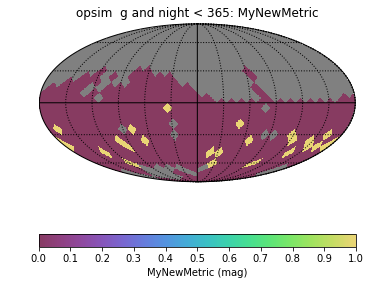

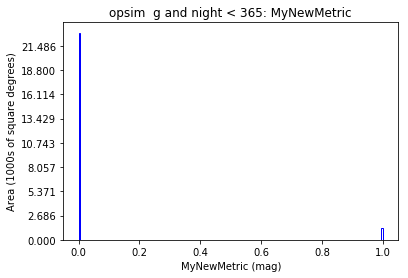

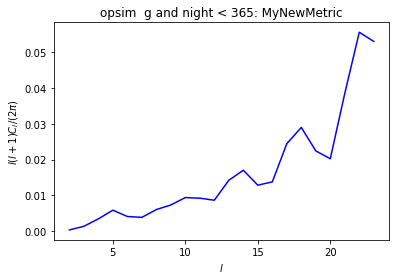

In [9]:
#plot the metrics in the metricBundleGroup after they have been run
bgroup.plotAll(closefigs=False)

## Expanding the sql constraint
An example select a single proposal from the database. In this case we will just get the WFD.
To determine the correct ID for the propsal, we used the `opsdb.fetchPropInfo()` and `opsdb.createSQLWhere('WFD', proptags)` methods.

In [10]:
#wfdWhere will be a string that can be added to the sqlcontraint
propids, proptags = opsdb.fetchPropInfo()
wfdWhere = opsdb.createSQLWhere('WFD', proptags)

In [11]:
#add wfdwhere to other contraints
sqlconstraint = 'filter = "g" and night < 365' + ' and ' +wfdWhere
#make the metricBundle again with the new sqlcontraint
myBundle = metricBundles.MetricBundle(metric1, slicer, sqlconstraint)

In [12]:
#Make the metricBundleBroup
bgroup = metricBundles.MetricBundleGroup({0: myBundle}, 
                                         opsdb, 
                                         outDir='newmetric_test', 
                                         resultsDb=None)

In [13]:
#Run the metricBundleGroup
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "g" and night < 365 and proposalId = 3 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 13571 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "g" and night < 365 and proposalId = 3" constraint now.


/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: -0.0157977  dipole: lon: -151.06, lat: -76.2416, amp: 0.210293
Plotting complete.


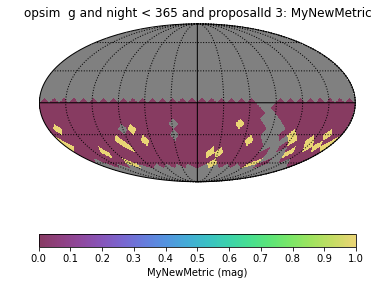

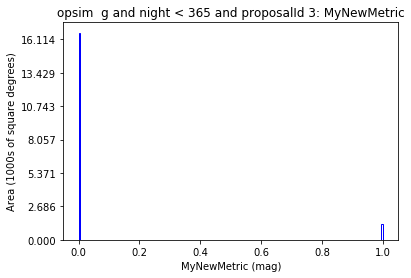

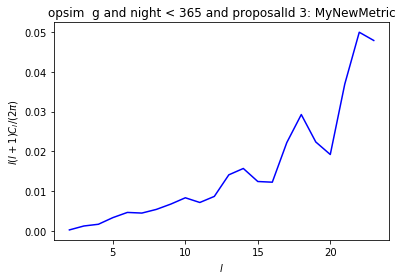

In [14]:
#Plot the metricBundleGroup
bgroup.plotAll(closefigs=False)

## Creating a batch of metrics
In this next section we will see how to construnct larger metricBundleGroups. We will use the function defined below to run `MyNewMetric` in the `WFD` and `NES` and in all filters.

This example shows a number of other useful tools in MAF, such as:
 - `plotFuncs`
 - `plotDict`
 - `metadata`
 - `makeBundlesDictFromList`

In [15]:
def MyMetricBatch(opsdb, slicer = None, n_nights = None):
    
    #list of filter names
    filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
    
    #dictionary key = filter name, value = mag_cut for that filter
    mag_limits = {'u': 26.5, 'g': 26.5, 'r': 26.5, 'i': 26.5, 'z': 26.0, 'y': 25.0}
    
    # use the fetchPropInfo method in the opsdb object to get the ids for the proposals
    # in the simulation
    propids, proptags = opsdb.fetchPropInfo()
    
    #list of strings for the proposals we want to use
    proposals = ['WFD','NES']
    
    #empty array where we will append metric bundles
    bundlelist = []
    
    #In this batch we are only going to plot the HealPixSkyMap
    #The metic bundles allow you to choose the plots with a list similar to this
    plotFuncs = [plots.HealpixSkyMap()]
    
    #if n_nights is not given use the whole survey
    if n_nights is None:
        n_nights = 3650
    
    #if no slicer is given use this healpix slicer
    if slicer is None:
        slicer = slicers.HealpixSlicer(nside=8)

    #create an sql string for the nights
    sql_night = 'night < "%s"' % n_nights
    
    #create a plot dictionary for the metric bundle.
    #MAF will set this up automatically, but you can control its conents.
    plotDict = {'colorMin':0,'colorMax':1}
    
    #loop through the proposals list
    for prop in proposals:
        
        #create the sql string to get the prop
        sql_prop = opsdb.createSQLWhere(prop, proptags)
        
        #loop through filter list
        for f in filterlist:
            
            #create sql string for filter
            sql_filter = 'filter = "%s"' % f 
            
            #combine the sql strings into a single sql contraint. An and is placed
            #between each one.
            sql_total = '(%s) and (%s) and (%s)' % (sql_filter, sql_night, sql_prop)
            
            #set the metadata of the metric bundle.
            #This makes the filenames easily readable and adds good plot titles.
            if prop == 'WFD':
                metadata = '%s band, WFD_' % (f) + sql_night.replace('"','')
            else:
                metadata = '%s band, NES_' % (f) + sql_night.replace('"','')
            
            #setup the metric with the mag limit for the given filter
            metric = MyNewMetric(mag_cut=mag_limits[f])
            
            #group everything we have created in the a metric bundle
            bundle = metricBundles.MetricBundle(metric = metric, 
                                                slicer = slicer, 
                                                constraint = sql_total,
                                                metadata = metadata,
                                                runName = 'baseline2018a',
                                                plotFuncs=plotFuncs,
                                                plotDict=plotDict)
            #append the current bundle to bundleist 
            bundlelist.append(bundle)
            #do loop again for next filter
    
    #After going through all of the filters make a metric bundle dictionary from bundlelist
    #there is a method in metricBundles in MAF that does this
    metric_bundle_dict = metricBundles.makeBundlesDictFromList(bundlelist)
    
    #return the metric bundle dict.
    return metric_bundle_dict

In [16]:
#run the function we just defined
batch_dict = MyMetricBatch(opsdb)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


In [17]:
#look at the batch_dict returned by the function
batch_dict

{'baseline2018a_MyNewMetric_u_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e819ae48>,
 'baseline2018a_MyNewMetric_g_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e83d0278>,
 'baseline2018a_MyNewMetric_r_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e832dba8>,
 'baseline2018a_MyNewMetric_i_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e848e128>,
 'baseline2018a_MyNewMetric_z_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e81e5d30>,
 'baseline2018a_MyNewMetric_y_band_WFD_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e819ae80>,
 'baseline2018a_MyNewMetric_u_band_NES_night_lt_3650_HEAL': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb7e819ab38>,
 'baseline2018a_MyNewMetric_g_band_NES_night_lt_3650_HE

In [18]:
#make a metricBundleGroup using the batch_dict
#this is what will connect the metrics to the opsdb
batch_group = metricBundles.MetricBundleGroup(batch_dict, 
                                              opsdb, 
                                              outDir='newmetric_test', 
                                              resultsDb=None)

In [19]:
#run all of the metrics
batch_group.runAll()

Querying database SummaryAllProps with constraint (filter = "u") and (night < "3650") and (proposalId = 3) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 138900 visits
Running:  ['baseline2018a_MyNewMetric_u_band_WFD_night_lt_3650_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint (filter = "i") and (night < "3650") and (proposalId = 1) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 38125 visits
Running:  ['baseline2018a_MyNewMetric_i_band_NES_night_lt_3650_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint (filter = "u") and (night < "3650") and (proposalId = 1) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']


/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint (filter = "u") and (night < "3650") and (proposalId = 1)
  warnings.warn('No data matching constraint %s' % constraint)
/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['MyNewMetric : u band, NES_night < 3650 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint (filter = "y") and (night < "3650") and (proposalId = 1) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']


/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:261: UserWarning: No data matching constraint (filter = "y") and (night < "3650") and (proposalId = 1)
  warnings.warn('No data matching constraint %s' % constraint)
/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:265: UserWarning:  This means skipping metrics ['MyNewMetric : y band, NES_night < 3650 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint (filter = "z") and (night < "3650") and (proposalId = 3) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 412599 visits
Running:  ['baseline2018a_MyNewMetric_z_band_WFD_night_lt_3650_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint (filter = "r") and (night < "3650") and (proposalId = 1) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 38256 visits
Running:  ['baseline2018a_MyNewMetric_r_band_NES_night_lt_3650_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint (filter = "g") and (night < "3650") and (proposalId = 1) for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 16761 visits
Running:  ['baseline2018a_MyNewMetric_g_band_NES_night_lt_3650_HEAL']
Completed metric generation.
Running reduce methods.
Running summ

Plotting figures with "(filter = "u") and (night < "3650") and (proposalId = 3)" constraint now.
Plotting complete.
Plotting figures with "(filter = "i") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "u") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "y") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "z") and (night < "3650") and (proposalId = 3)" constraint now.


/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:535: UserWarning: MetricBundle (baseline2018a_MyNewMetric_u_band_NES_night_lt_3650_HEAL) has no attribute "metricValues". Either the values have not been calculated or they have been deleted.
  warnings.warn(msg)
/home/docmaf/lsst_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:535: UserWarning: MetricBundle (baseline2018a_MyNewMetric_y_band_NES_night_lt_3650_HEAL) has no attribute "metricValues". Either the values have not been calculated or they have been deleted.
  warnings.warn(msg)


Plotting complete.
Plotting figures with "(filter = "r") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "g") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "i") and (night < "3650") and (proposalId = 3)" constraint now.
Plotting complete.
Plotting figures with "(filter = "z") and (night < "3650") and (proposalId = 1)" constraint now.
Plotting complete.
Plotting figures with "(filter = "y") and (night < "3650") and (proposalId = 3)" constraint now.
Plotting complete.
Plotting figures with "(filter = "r") and (night < "3650") and (proposalId = 3)" constraint now.
Plotting complete.
Plotting figures with "(filter = "g") and (night < "3650") and (proposalId = 3)" constraint now.
Plotting complete.


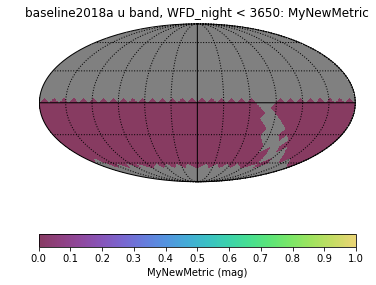

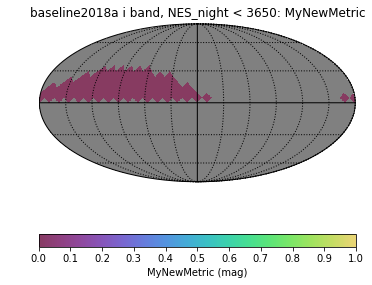

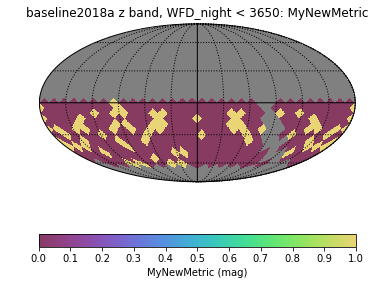

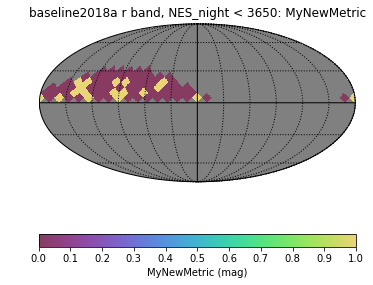

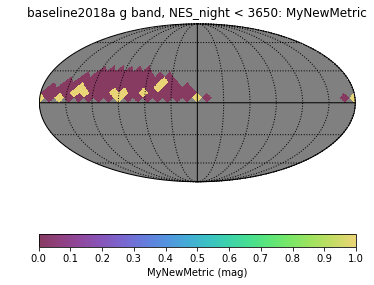

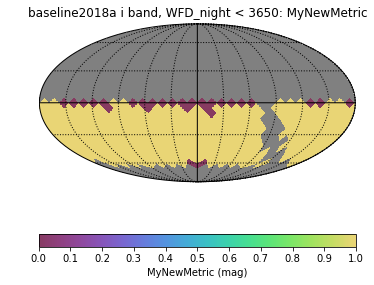

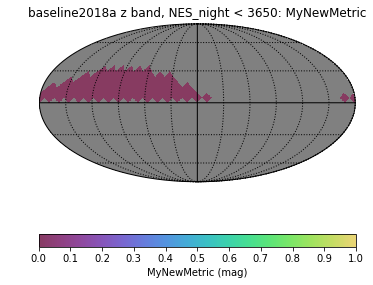

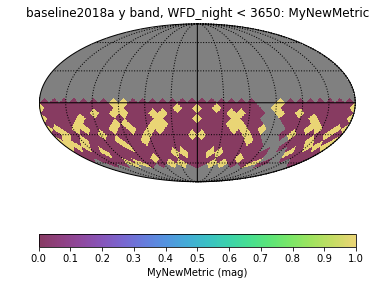

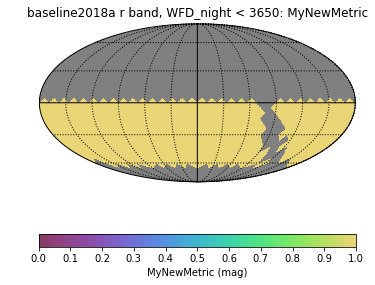

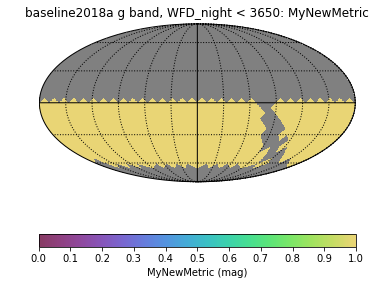

In [20]:
#Plot the metrics
#note only the skymap are being plotted
batch_group.plotAll(closefigs=False)